##**Kasus 5: Optimalisasi Produksi Listrik di Tengah Tantangan Energi Nasional**

PT Nusantara Energi Bersatu (NEB), sebuah perusahaan listrik yang baru bertransformasi dari BUMN menjadi perusahaan terbuka, sedang menghadapi tantangan besar dalam memenuhi kebutuhan listrik nasional yang terus meningkat. Permintaan listrik yang sangat fluktuatif sepanjang hari dan tuntutan untuk beroperasi secara lebih efisien serta ramah lingkungan menjadi perhatian utama.

Pola konsumsi listrik harian menunjukkan fluktuasi sebagai berikut:
- 00.00 - 06.00: 15.000 MW
- 06.00 - 09.00: 30.000 MW
- 09.00 - 15.00: 25.000 MW
- 15.00 - 18.00: 40.000 MW
- 18.00 - 24.00: 27.000 MW

Perusahaan memiliki tiga jenis pembangkit listrik dengan karakteristik yang berbeda-beda:

Tipe 1:
- Jumlah 12 unit
- Kapasitas: Min 850 MW, Maks 2000 MW
- Biaya/jam pada kapasitas min: Rp 15.000.000
- Biaya tambahan per MW di atas min: Rp 30.000/jam
- Biaya start-up: Rp 30.000.000

Tipe 2:
- Jumlah 10 unit
- Kapasitas: Min 1250 MW, Maks 1750 MW
- Biaya/jam pada kapasitas min: Rp 39.000.000
- Biaya tambahan per MW di atas min: Rp 19.500/jam
- Biaya start-up: Rp 15.000.000

Tipe 3:
- Jumlah 5 unit
- Kapasitas: Min 1500 MW, Maks 4000 MW
- Biaya/jam pada kapasitas min: Rp 45.000.000
- Biaya tambahan per MW di atas min: Rp 45.000/jam
- Biaya start-up: Rp 7.500.000

Kompleksitas situasi bertambah dengan persyaratan regulator untuk menyediakan cadangan daya minimal 15% di atas permintaan untuk mengantisipasi lonjakan mendadak.

PT Nusantara Energi Bersatu (NEB) menghadapi tantangan kompleks untuk mengoptimalkan produksi listrik guna memenuhi permintaan yang fluktuatif dengan biaya yang efisien. Perusahaan harus menentukan kombinasi operasi pembangkit yang paling hemat, menghitung biaya marginal untuk penetapan tarif, serta menganalisis dampak finansial dari kebijakan cadangan daya. Semua keputusan operasional ini tidak hanya berfokus pada aspek ekonomi, tetapi juga harus mempertimbangkan dampak lingkungan dan sosial untuk mendukung keberlanjutan energi nasional ke depannya.

##**Penyelesaian**

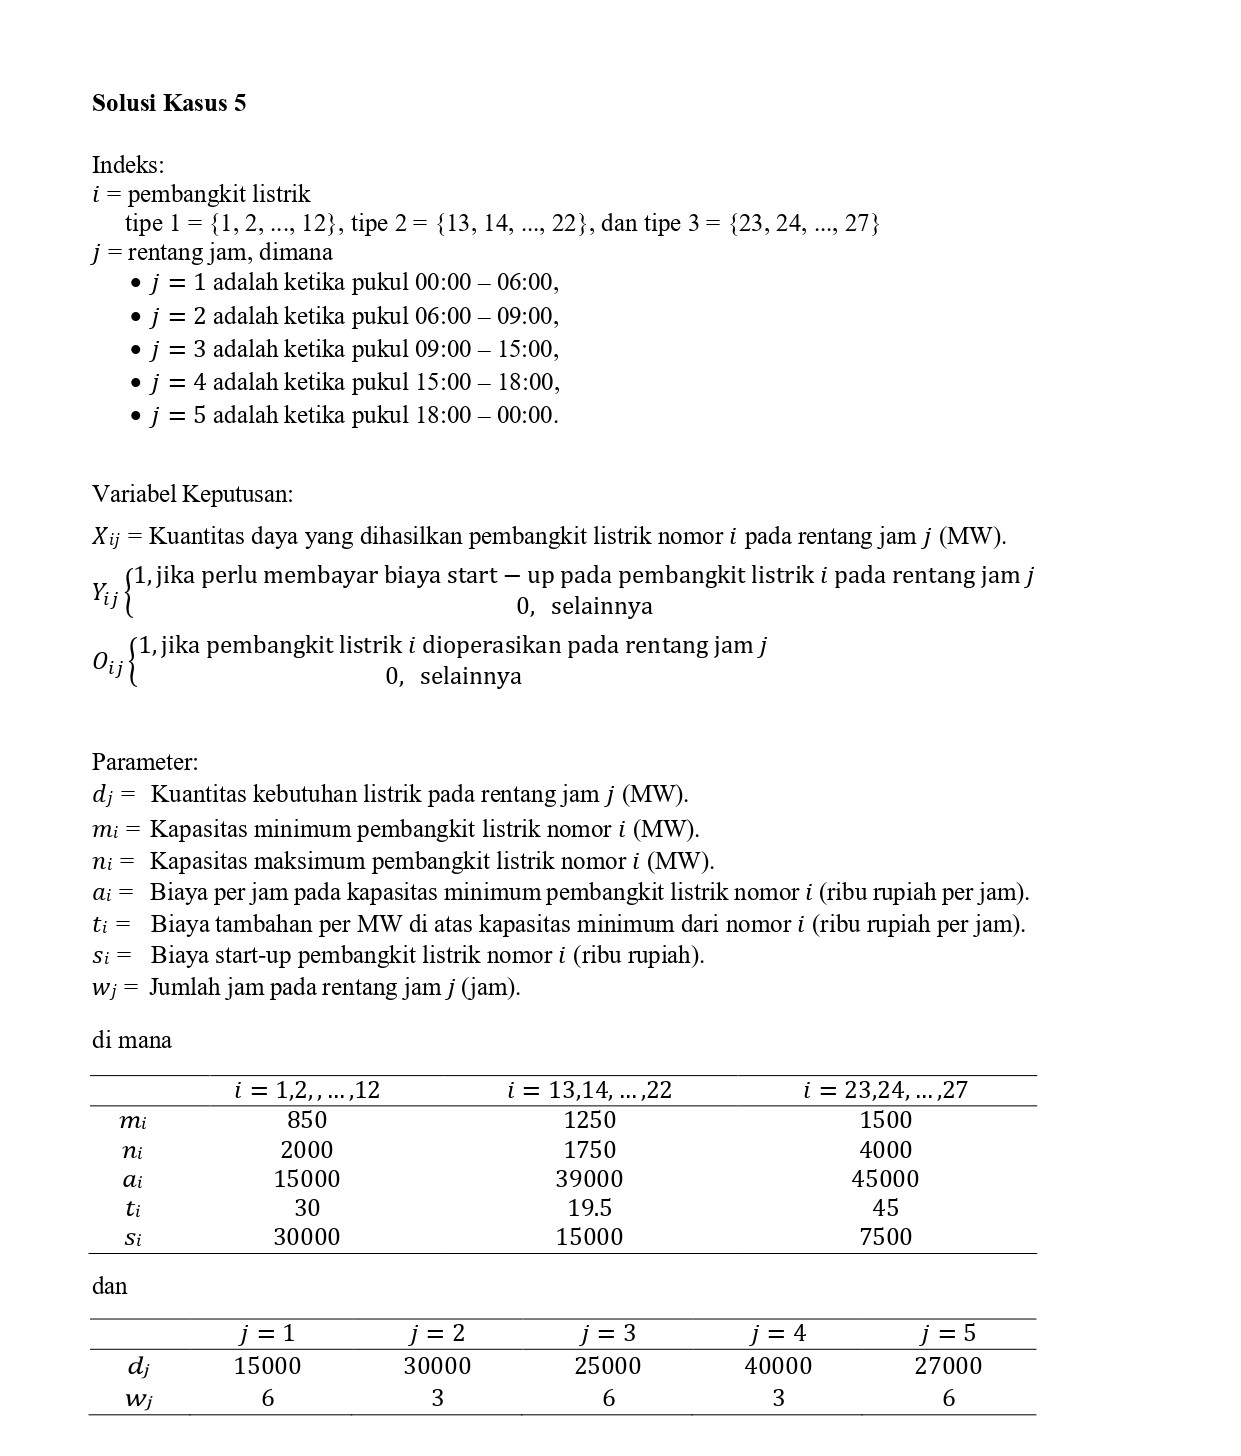

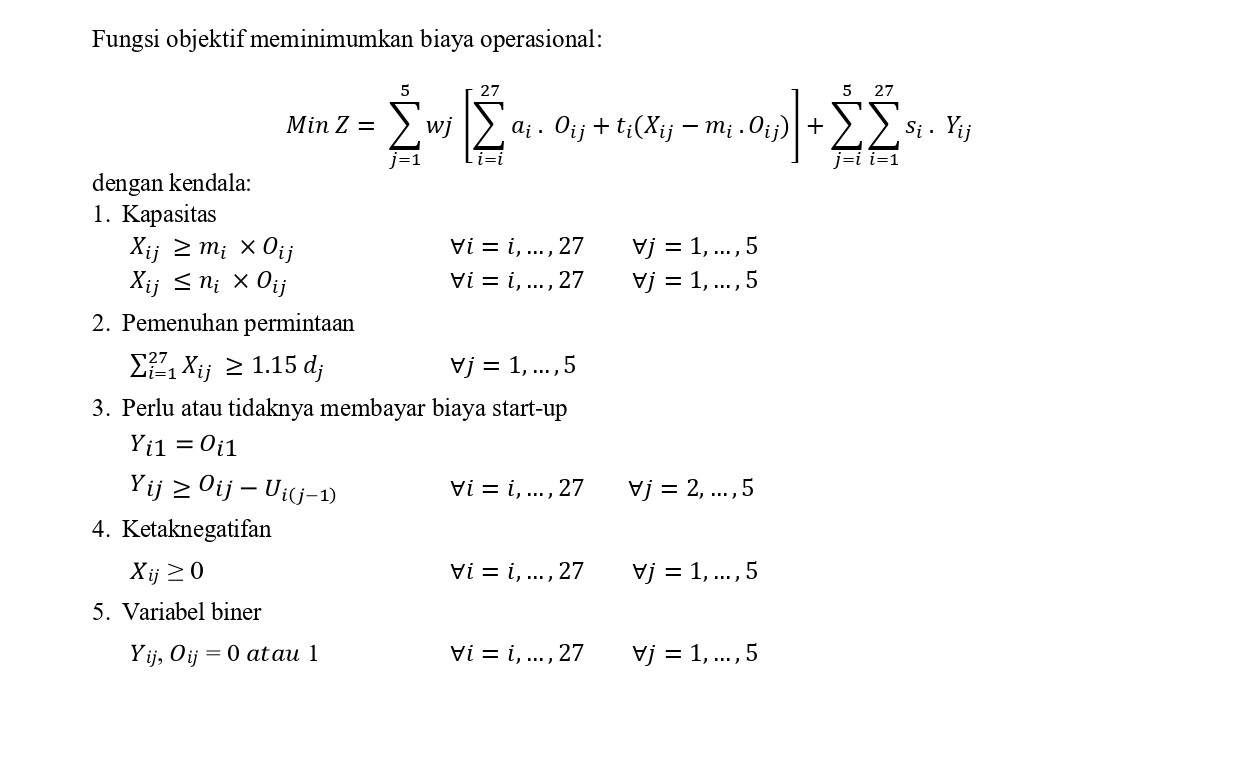

##**Implementasi Pyomo**

Pyomo adalah alat bantu dalam Riset Operasi yang menggunakan Python untuk membuat dan menyelesaikan model matematika guna mengoptimalkan solusi dari berbagai masalah optimasi (maksimisasi dan minimisasi).

In [ ]:
!pip install pyomo
!apt-get install -y -qq glpk-utils

In [ ]:
from pyomo.environ import *

In [ ]:
# Model
model = ConcreteModel()

# Set indeks
model.I = Set(initialize=[i for i in range(1, 28)])  # Pembangkit 1 hingga 27
model.J = Set(initialize=[1, 2, 3, 4, 5])           # Rentang jam 1 hingga 5

# Parameter
# Data untuk tipe pembangkit
mi_data = {
    **{i: 850 for i in range(1, 13)},
    **{i: 1250 for i in range(13, 23)},
    **{i: 1500 for i in range(23, 28)}}

ni_data = {
    **{i: 2000 for i in range(1, 13)},
    **{i: 1750 for i in range(13, 23)},
    **{i: 4000 for i in range(23, 28)}}

ai_data = {
    **{i: 15000 for i in range(1, 13)},
    **{i: 39000 for i in range(13, 23)},
    **{i: 45000 for i in range(23, 28)}}

ti_data = {
    **{i: 30 for i in range(1, 13)},
    **{i: 19.5 for i in range(13, 23)},
    **{i: 45 for i in range(23, 28)}}

si_data = {
    **{i: 30000 for i in range(1, 13)},
    **{i: 15000 for i in range(13, 23)},
    **{i: 7500 for i in range(23, 28)}}

# Data untuk rentang jam
dj_data = {1: 15000, 2: 30000, 3: 25000, 4: 40000, 5: 27000}
wj_data = {1: 6, 2: 3, 3: 6, 4: 3, 5: 6}

# Mendefinisikan parameter dalam model
model.mi = Param(model.I, initialize=mi_data)
model.ni = Param(model.I, initialize=ni_data)
model.ai = Param(model.I, initialize=ai_data)
model.ti = Param(model.I, initialize=ti_data)
model.si = Param(model.I, initialize=si_data)
model.dj = Param(model.J, initialize=dj_data)
model.wj = Param(model.J, initialize=wj_data)

# Variabel keputusan
model.X = Var(model.I, model.J, domain=NonNegativeReals)
model.Y = Var(model.I, model.J, domain=Binary)
model.O = Var(model.I, model.J, domain=Binary)

# Fungsi objektif
def objective_rule(model):
    term1 = sum(model.wj[j] * (
        sum(model.ai[i] * model.O[i, j] for i in model.I) +
        sum(model.ti[i] * (model.X[i, j] - model.mi[i] * model.O[i, j]) for i in model.I)
    ) for j in model.J)
    term2 = sum(model.si[i] * model.Y[i, j] for i in model.I for j in model.J)
    return term1 + term2

model.obj = Objective(rule=objective_rule, sense=minimize)

# Kendala
# 1. Kapasitas minimum dan maksimum
def min_capacity_rule(model, i, j):
    return model.X[i, j] >= model.mi[i] * model.O[i, j]

def max_capacity_rule(model, i, j):
    return model.X[i, j] <= model.ni[i] * model.O[i, j]

model.min_capacity = Constraint(model.I, model.J, rule=min_capacity_rule)
model.max_capacity = Constraint(model.I, model.J, rule=max_capacity_rule)

# 2. Pemenuhan permintaan (dengan cadangan 15%)
def demand_rule(model, j):
    return sum(model.X[i, j] for i in model.I) >= 1.15 * model.dj[j]

model.demand = Constraint(model.J, rule=demand_rule)

# 3. Biaya start-up
def startup_rule_initial(model, i):
    return model.Y[i, 1] == model.O[i, 1]

def startup_rule_subsequent(model, i, j):
    if j > 1:
        return model.Y[i, j] >= model.O[i, j] - model.O[i, j-1]
    else:
        return Constraint.Skip

model.startup_initial = Constraint(model.I, rule=startup_rule_initial)
model.startup_subsequent = Constraint(model.I, model.J, rule=startup_rule_subsequent)

# Memecahkan model
solver = SolverFactory('glpk')
results = solver.solve(model)

# Menampilkan hasil
print("Status Solusi:", results.solver.termination_condition)
print(f"Biaya Minimum: Rp {value(model.obj)*1000:,.0f}\n")

Status Solusi: optimal
Biaya Minimum: Rp 17,857,500,000



In [ ]:
# Ringkasan per jam
print("\nRINGKASAN PER JAM:")
print("=" * 77)
print(f"{'Jam':<8} {'Waktu':<15} {'Permintaan':<12} {'Produksi':<12} {'Cadangan':<12} {'% Cadangan':<12}")
print("-" * 77)

for j in model.J:
    total_production = sum(value(model.X[i, j]) for i in model.I)
    demand = model.dj[j]
    reserve = total_production - demand
    reserve_percent = (reserve / demand) * 100 if demand > 0 else 0

    waktu_map = {1: "00:00-06:00", 2: "06:00-09:00", 3: "09:00-15:00",
                4: "15:00-18:00", 5: "18:00-00:00"}

    print(f"{j:<8} {waktu_map[j]:<15} {demand:<12,.0f} {total_production:<12,.0f} "
          f"{reserve:<12,.0f} {reserve_percent:<12.1f}")

print("=" * 77)


# Biaya breakdown
print("\nBREAKDOWN BIAYA:\n")
total_biaya_operasi = 0
total_biaya_startup = 0

for j in model.J:
    biaya_operasi_jam = model.wj[j] * (
        sum(model.ai[i] * value(model.O[i, j]) for i in model.I) +
        sum(model.ti[i] * (value(model.X[i, j]) - model.mi[i] * value(model.O[i, j])) for i in model.I)
    )
    biaya_startup_jam = sum(model.si[i] * value(model.Y[i, j]) for i in model.I)

    total_biaya_operasi += biaya_operasi_jam
    total_biaya_startup += biaya_startup_jam

    print(f"Jam {j} ({waktu_map[j]}):")
    print(f"  Biaya Operasi: Rp {biaya_operasi_jam * 1000:,.0f}")
    print(f"  Biaya Start-up: Rp {biaya_startup_jam  * 1000:,.0f}")
    print(f"  Total: Rp {(biaya_operasi_jam + biaya_startup_jam)  * 1000:,.0f}\n")

print(f"TOTAL BIAYA OPERASI: Rp {total_biaya_operasi * 1000:,.0f}")
print(f"TOTAL BIAYA START-UP: Rp {total_biaya_startup * 1000:,.0f}")
print(f"TOTAL KESELURUHAN: Rp {(total_biaya_operasi + total_biaya_startup) * 1000:,.0f}")


RINGKASAN PER JAM:
Jam      Waktu           Permintaan   Produksi     Cadangan     % Cadangan  
-----------------------------------------------------------------------------
1        00:00-06:00     15,000       17,250       2,250        15.0        
2        06:00-09:00     30,000       34,500       4,500        15.0        
3        09:00-15:00     25,000       28,750       3,750        15.0        
4        15:00-18:00     40,000       46,000       6,000        15.0        
5        18:00-00:00     27,000       31,050       4,050        15.0        

BREAKDOWN BIAYA:

Jam 1 (00:00-06:00):
  Biaya Operasi: Rp 2,259,000,000
  Biaya Start-up: Rp 420,000,000
  Total: Rp 2,679,000,000

Jam 2 (06:00-09:00):
  Biaya Operasi: Rp 2,614,500,000
  Biaya Start-up: Rp 90,000,000
  Total: Rp 2,704,500,000

Jam 3 (09:00-15:00):
  Biaya Operasi: Rp 4,194,000,000
  Biaya Start-up: Rp 0
  Total: Rp 4,194,000,000

Jam 4 (15:00-18:00):
  Biaya Operasi: Rp 3,649,500,000
  Biaya Start-up: Rp 22,500,000


In [ ]:
# Detail per pembangkit
print("\nDETAIL OPERASI PEMBANGKIT:")

# Kelompokkan pembangkit berdasarkan tipe
tipe_1 = list(range(1, 13))
tipe_2 = list(range(13, 23))
tipe_3 = list(range(23, 28))

for tipe, pembangkit_list, tipe_name in [
    (1, tipe_1, "Tipe 1 (Pembangkit 1-12)"),
    (2, tipe_2, "Tipe 2 (Pembangkit 13-22)"),
    (3, tipe_3, "Tipe 3 (Pembangkit 23-27)")
]:
    print(f"\n{tipe_name}:")
    print("-" * 62)
    print(f"{'Pembangkit':<12} {'Status':<12} {'Total Jam':<10} {'Total Produksi':<15} {'Start-up':<10}")
    print("-" * 62)

    for i in pembangkit_list:
        total_jam_operasi = sum(value(model.O[i, j]) for j in model.J)
        total_produksi = sum(value(model.X[i, j]) for j in model.J)
        total_startup = sum(value(model.Y[i, j]) for j in model.J)
        status = "Aktif" if total_jam_operasi > 0 else "Non-aktif"

        print(f"{i:<12} {status:<12} {total_jam_operasi:<10} {total_produksi:<15,.0f} {total_startup:<10}")


DETAIL OPERASI PEMBANGKIT:

Tipe 1 (Pembangkit 1-12):
--------------------------------------------------------------
Pembangkit   Status       Total Jam  Total Produksi  Start-up  
--------------------------------------------------------------
1            Aktif        5.0        8,250           1.0       
2            Aktif        5.0        5,400           1.0       
3            Aktif        5.0        5,400           1.0       
4            Aktif        5.0        5,400           1.0       
5            Aktif        5.0        5,400           1.0       
6            Aktif        5.0        5,400           1.0       
7            Aktif        5.0        5,400           1.0       
8            Aktif        5.0        6,550           1.0       
9            Aktif        5.0        6,550           1.0       
10           Aktif        5.0        6,550           1.0       
11           Aktif        5.0        6,550           1.0       
12           Aktif        5.0        7,700         

In [ ]:
# Detail per jam untuk pembangkit yang aktif
print("DETAIL PRODUKSI PER JAM UNTUK PEMBANGKIT YANG AKTIF:")

waktu_map = {1: "00:00-06:00", 2: "06:00-09:00", 3: "09:00-15:00",
            4: "15:00-18:00", 5: "18:00-00:00"}

for j in model.J:
    print(f"\nJam {j} ({waktu_map[j]}):")
    print("-" * 72)
    print(f"{'Pembangkit':<12} {'Tipe':<6} {'Status':<8} {'Produksi (MW)':<15} {'Kapasitas':<15} {'Start-up':<10}")
    print("-" * 72)

    active_plants = []
    for i in model.I:
        if value(model.O[i, j]) > 0.5:
            # Tentukan tipe pembangkit
            if 1 <= i <= 12:
                tipe = 1
            elif 13 <= i <= 22:
                tipe = 2
            else:
                tipe = 3

            active_plants.append((i, tipe, value(model.X[i, j]), value(model.Y[i, j])))

    # Urutkan berdasarkan tipe kemudian nomor pembangkit
    active_plants.sort(key=lambda x: (x[1], x[0]))

    for plant in active_plants:
        i, tipe, production, startup = plant
        status = "ON" if value(model.O[i, j]) > 0.5 else "OFF"
        startup_status = "YA" if startup > 0.5 else "TIDAK"
        capacity_used = f"{production:.0f}/{model.ni[i]}"

        print(f"{i:<12} {tipe:<6} {status:<8} {production:<15,.0f} {capacity_used:<15} {startup_status:<10}")

    total_jam = sum(value(model.O[i, j]) for i in model.I)
    total_production = sum(value(model.X[i, j]) for i in model.I)
    startups_jam = sum(value(model.Y[i, j]) for i in model.I)

    print("-" * 72)
    print(f"{'TOTAL':<12} {'-':<6} {'-':<8} {total_production:<15,.0f} {'-':<15} {startups_jam:<10}")
    print(f"{'PEMBANGKIT AKTIF:':<12} {total_jam} unit")

DETAIL PRODUKSI PER JAM UNTUK PEMBANGKIT YANG AKTIF:

Jam 1 (00:00-06:00):
------------------------------------------------------------------------
Pembangkit   Tipe   Status   Produksi (MW)   Kapasitas       Start-up  
------------------------------------------------------------------------
1            1      ON       900             900/2000        YA        
2            1      ON       850             850/2000        YA        
3            1      ON       850             850/2000        YA        
4            1      ON       850             850/2000        YA        
5            1      ON       850             850/2000        YA        
6            1      ON       850             850/2000        YA        
7            1      ON       850             850/2000        YA        
8            1      ON       850             850/2000        YA        
9            1      ON       850             850/2000        YA        
10           1      ON       850             850/2000      



---


Berdasarkan hasil optimasi sistem pembangkitan listrik, solusi optimal berhasil dicapai dengan total biaya minimum sebesar **Rp 17.857.500.000**. Biaya ini mencakup seluruh biaya operasional dan start-up pembangkit selama periode 24 jam yang dibagi menjadi 5 rentang waktu.

Dari analisis hasil optimasi, terlihat bahwa sistem berhasil memenuhi kebutuhan listrik setiap jam dengan cadangan minimum 15% sesuai requirement. Produksi listrik diatur secara efisien dimana pembangkit-pembangkit dioperasikan pada kapasitas optimal untuk meminimalkan biaya while still meeting demand. Pembangkit dengan biaya operasional yang lebih rendah cenderung dioperasikan lebih lama, sementara pembangkit dengan biaya start-up tinggi dihidupkan hanya ketika benar-benar diperlukan. Beberapa pembangkit dioperasikan secara kontinyu, sementara lainnya dihidupkan dan dimatikan sesuai fluktuasi permintaan listrik selama sehari.

Detail produksi menunjukkan pola operasi yang responsive terhadap perubahan beban, dengan peningkatan jumlah pembangkit yang dioperasikan selama jam-jam puncak (seperti jam 15:00-18:00) dan pengurangan selama jam-jam off-peak. Pola ini mencerminkan strategi ekonomis dimana pembangkit dengan karakteristik biaya yang berbeda dioptimalkan penggunaannya sesuai dengan kebutuhan sistem.